<a href="https://colab.research.google.com/github/markiroberts/gogglecolab01/blob/main/Sim_01_StableFluids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
#pip install cmasher

  0%|          | 0/1 [00:00<?, ?it/s]

mag shape: (41, 41)
vector_field shape: (41, 41, 2)
mag shape: (41, 41)


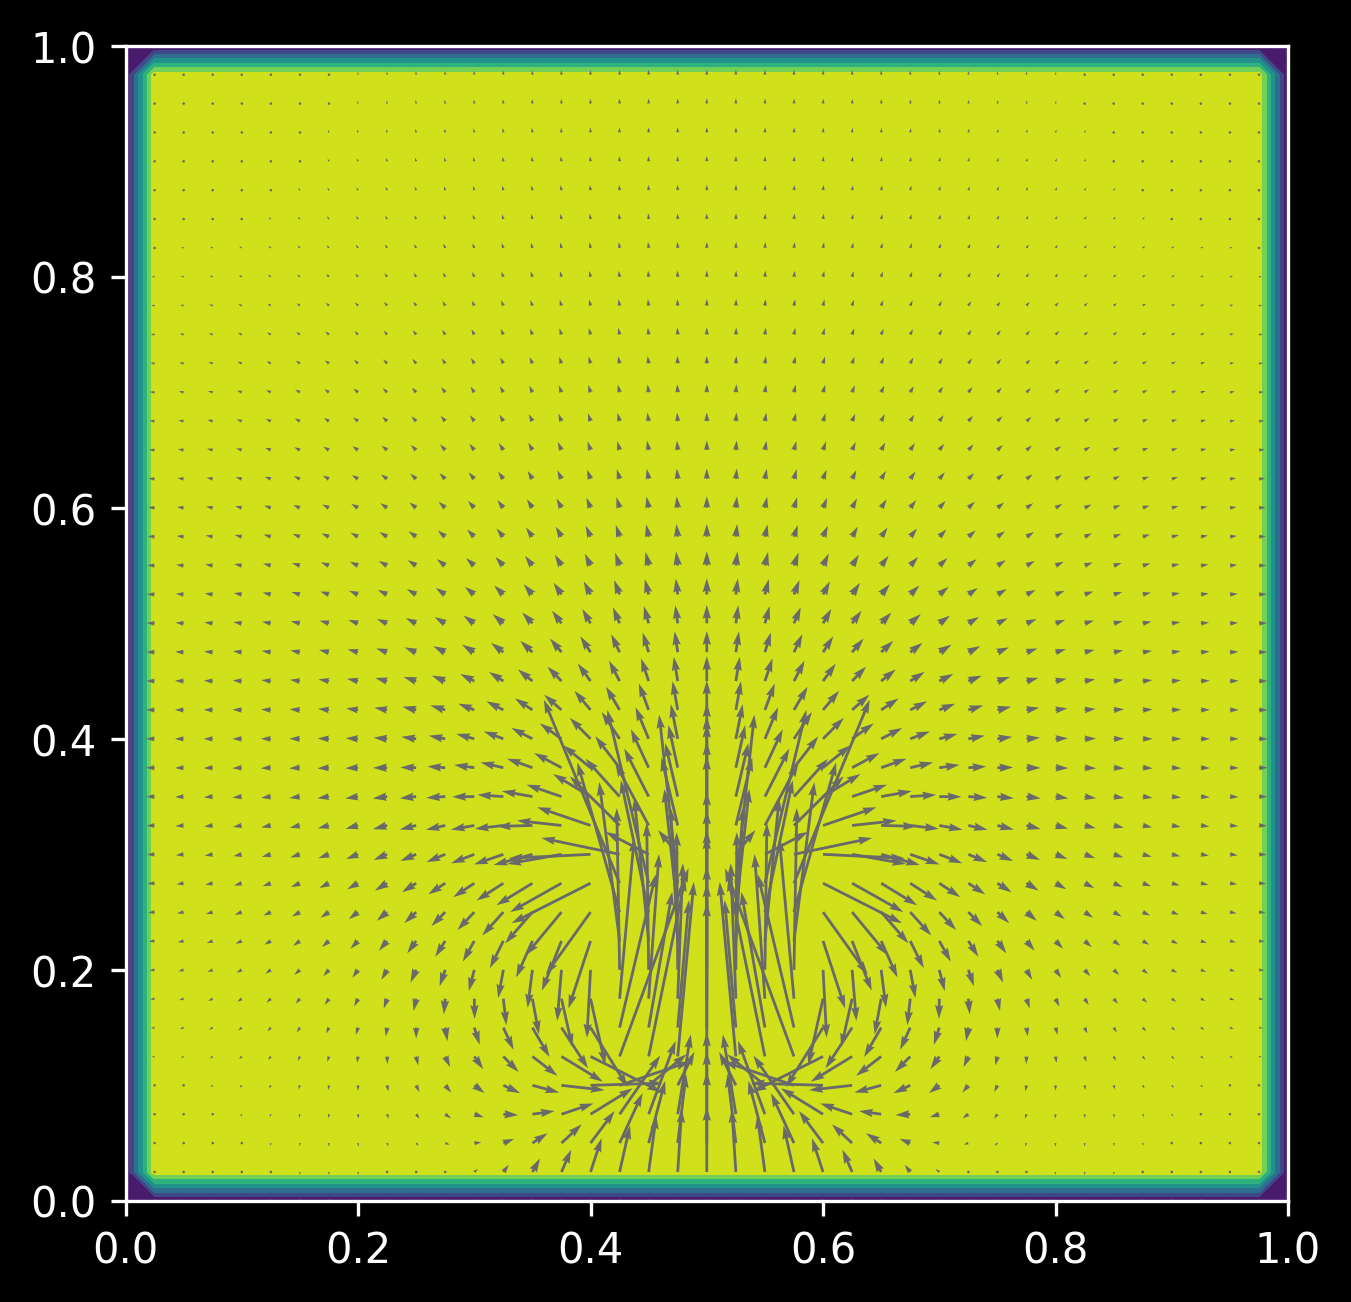

100%|██████████| 1/1 [00:00<00:00,  1.81it/s]

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.05283682 0.05283682 ... 0.05283682 0.05283682 0.        ]
 [0.         0.05283682 0.05283682 ... 0.05283682 0.05283682 0.        ]
 ...
 [0.         0.05283682 0.05283682 ... 0.05283682 0.05283682 0.        ]
 [0.         0.05283682 0.05283682 ... 0.05283682 0.05283682 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


<Figure size 640x480 with 0 Axes>

In [69]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt

#optional
import cmasher as cmr
from tqdm import tqdm

DOMAIN_SIZE = 1.0
N_POINTS = 41
N_TIME_STEPS = 1
TIME_STEP_LENGTH = 0.01

KINEMATIC_VISCOSITY = 0.0001
MAX_ITER_CG = None

def forcing_function(time, point):
  time_decay = np.maximum(
      2.0 - 0.5 * time,
      0.0
  )

  forced_value = np.where(
    time_decay *
    (
    (point[0] > 0.4)
    &
    (point[0] < 0.6)
    &
    (point[1] > 0.1)
    &
    (point[1] < 0.3)
    ),
    np.array([0.0, 1.0]),
    np.array([0.0, 0.0])
  )
  return forced_value

def main():
  element_length = DOMAIN_SIZE / (N_POINTS + 1)
  scalar_shape = (N_POINTS, N_POINTS)
# scalar degrees of freedom
  scalar_dof = N_POINTS ** 2
  vector_shape = (N_POINTS, N_POINTS, 2)
  vector_dof = N_POINTS**2 * 2

  x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
  y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

  # using the ij indexing makes differential operatiors more logical
  # take care when plotting in matplotlib
  X, Y = np.meshgrid(x, y, indexing="ij")
  coordinates = np.concatenate(
      (
          X[..., np.newaxis],
          Y[..., np.newaxis],
      ),
      axis=-1
  )

  forcing_function_vectorized = np.vectorize(
      pyfunc=forcing_function,
      signature="(),(d)->(d)",
  )

  def advect(field, vector_field):
    backtraced_positions = np.clip(
        (
          coordinates
          -
          TIME_STEP_LENGTH
          *
          vector_field
        ),
        0.0,
        DOMAIN_SIZE,
    )

    advected_field = interpolate.interpn(
        points=(x,y),
        values=field,
        xi=backtraced_positions
    )

    return advected_field

  def diffusion_operator(vector_field_flattened):
    vector_field = vector_field_flattened.reshape(vector_shape) # vector shape = 41,41,2
    diffusion_applied = (
        vector_field
        -
        KINEMATIC_VISCOSITY
        *
        TIME_STEP_LENGTH
        *
        laplace(vector_field)
    )
    return diffusion_applied.flatten()

  def poisson_operator(field_flattened):
    field = field_flattened.reshape(scalar_shape)
    poisson_applied = laplace(field)
    return poisson_applied.flatten()


  def laplace(field):
    diff = np.zeros_like(field)
    diff[1:-1, 1:-1] = (
      (
        field[0:-2, 1:-1]
        +
        field[1:-1, 0:-2]
        -
        field[1:-1, 1:-1] * 4
        +
        field[2:  , 1:-1]
        +
        field[1:-1, 2:  ]
      ) / ( element_length**2 )
    )
    return diff

  def partial_derivative_x(field):
    diff = np.zeros_like(field)

    diff[1:-1, 1:-1] = (
        (
            field[2:  , 1:-1]
            -
            field[0:-2, 1:-1]
        ) / ( 2 * element_length )
    )
    return diff

  def partial_derivative_y(field):
    diff = np.zeros_like(field)
    diff[1:-1, 1:-1] = (
        (
            field[1:-1,  2: ]
            -
            field[1:-1, 0:-2]
        ) / ( 2 * element_length )
    )
    return diff

  def divergence(vector_field):
    divergence_applied = (
        partial_derivative_x(vector_field[..., 0])
        +
        partial_derivative_y(vector_field[..., 1])
    )
    return divergence_applied


  def gradient(field): #goes up a dimension, sclar field -> vector
    gradient_applied = np.concatenate(
      (
          partial_derivative_x(field)[..., np.newaxis],
          partial_derivative_y(field)[..., np.newaxis],

      ),
      axis=-1
    )
    return gradient_applied

  def curl_2d(vector_field):
    curl_applied = (
        partial_derivative_x(vector_field[..., 1]) # partial derivate in x for vector fields y component
        -
        partial_derivative_y(vector_field[..., 0]) # partial derivate in y for vector fields x component
    )
    return curl_applied


  def magnitude(vector_field):
    mag = np.zeros(scalar_shape)
    print("mag shape:", mag.shape)
    print("vector_field shape:", vector_field.shape)
    mag[1:-1, 1:-1]  =  np.linalg.norm(vector_field[1:-1, 1:-1])  #)    np.magnitude(field[1:-1, 1:-1])#   vector_field[1:-1, 1:-1][0][0]
    print("mag shape:", mag.shape)
    return mag
#    mag[1:-1, 1:-1] = (
#       vector_field[1:-1, 1:-1][0] )
#    return mag

  plt.style.use("dark_background")
  plt.figure(figsize=(5,5), dpi=300)


  velocitieres_prev = np.zeros(vector_shape)
  time_current = 0.0
  for i in tqdm(range(N_TIME_STEPS)):
    time_current += TIME_STEP_LENGTH

    forces = forcing_function_vectorized(
        time_current,
        coordinates,
        )
    # (1) Apply Forces
    velocities_forces_applied = (
        velocitieres_prev
        +
        TIME_STEP_LENGTH
        *
        forces
    )

    # (2) Non-linear convection (=self-advection)
    velocities_advected = advect(
        field         =velocities_forces_applied,
        vector_field  =velocities_forces_applied
    )

    A = splinalg.LinearOperator(
        shape=(vector_dof,vector_dof),
        matvec=diffusion_operator)
    # (3) Diffusion
    velocities_diffused = splinalg.cg(
        A = splinalg.LinearOperator(
          shape=(vector_dof,vector_dof),
          matvec=diffusion_operator),
        b = velocities_advected.flatten(),
        maxiter=MAX_ITER_CG,
    )[0].reshape(vector_shape)

    # (4.1) Compute a pressure correction
    pressure = splinalg.cg(
        A = splinalg.LinearOperator(
            shape=(scalar_dof,scalar_dof),
            matvec=poisson_operator),
        b = divergence(velocities_diffused).flatten(),
        maxiter=MAX_ITER_CG,
    )[0].reshape(scalar_shape)

    # (4.2) Correct velocities to be incomprehisble
    velocities_projected = (
        velocities_diffused
        -
        gradient(pressure)
    )

    # Advance to next
    velocities_prev = velocities_projected

    curl = curl_2d(velocities_projected)
    mag = magnitude(velocities_projected)

    plt.contourf(
        X,
        Y,
        mag,
    )

    plt.quiver(
        X,
        Y,
        velocities_projected[..., 0],
        velocities_projected[..., 1],
        color="dimgray"
    )
    plt.draw()
    plt.pause(0.0001)
    plt.clf()

  print(mag)


if __name__ == "__main__":
  main()